# TITANIC : Logistic Regression
## Goal - Predict who surivies and who doesn't

<img src="titanic_image.jpg">

- Source(https://bit.ly/35w815L)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import sklearn

from pandas import Series, DataFrame
from pylab import rcParams
from sklearn import preprocessing

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score

In [3]:
%matplotlib inline
rcParams['figure.figsize'] = 5, 4
sb.set_style('whitegrid')

## Dataset

In [5]:
tit = pd.read_csv('titanic-training-data.csv')
tit.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## FEATURES

Survived - Survival (0 = No; 1 = Yes)<br>
Pclass - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)<br>
Name - Name<br>
Sex - Sex<br>
Age - Age<br>
SibSp - Number of Siblings/Spouses Aboard<br>
Parch - Number of Parents/Children Aboard<br>
Ticket - Ticket Number<br>
Fare - Passenger Fare (British pound)<br>
Cabin - Cabin<br>
Embarked - Port of Embarkation (C = Cherbourg, France; Q = Queenstown, UK; S = Southampton - Cobh, Ireland)

### Is our target variable binary?

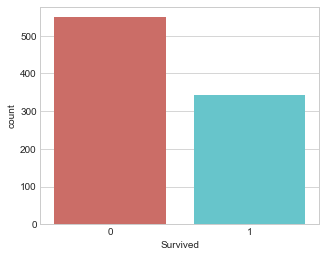

In [6]:
sb.countplot(x='Survived', data=tit, palette ='hls')

## Checking for missing values

In [9]:
tit.isnull().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

In [10]:
tit.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [11]:
tit.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Treating missing values

In [12]:
tit.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [13]:
titanic_data=tit.drop(['Name','Ticket', 'Cabin'], axis=1)
titanic_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


## Impute missing values

- we will use the Parch feature to give us a better mean estimate 

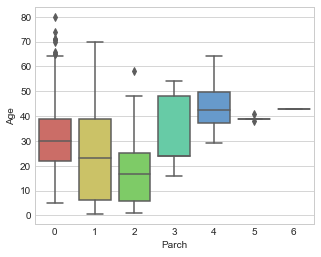

In [15]:
sb.boxplot(x='Parch', y='Age', data=titanic_data, palette='hls')

In [17]:
parch_groups = titanic_data.groupby(titanic_data['Parch'])
parch_groups.mean()

,PassengerId,Survived,Pclass,Age,SibSp,Fare
Parch,,,,,,
0,445.255162,0.343658,2.321534,32.178503,0.237463,25.586774
1,465.110169,0.550847,2.203390,24.422000,1.084746,46.778180
2,416.662500,0.500000,2.275000,17.216912,2.062500,64.337604
3,579.200000,0.600000,2.600000,33.200000,1.000000,25.951660
4,384.000000,0.000000,2.500000,44.500000,0.750000,84.968750
5,435.200000,0.200000,3.000000,39.200000,0.600000,32.550000
6,679.000000,0.000000,3.000000,43.000000,1.000000,46.900000


In [19]:
def age_approx(cols):
    Age =cols[0]
    Parch=cols[0]
    
    if pd.isnull(Age):
        if Parch == 0:
            return 32
        elif Parch == 1:
            return 24
        elif Parch == 2:
            return 17
        elif Parch == 3:
            return 33
        elif Parch == 4:
            return 45
        else:
            return 30
    else:
        return Age
        

In [21]:
titanic_data['Age']=titanic_data[['Age', 'Parch']].apply(age_approx, axis=1)

In [23]:
titanic_data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       2
dtype: int64

In [24]:
titanic_data.dropna(inplace=True)
titanic_data.reset_index(inplace=True, drop=True)

In [25]:
print(titanic_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 9 columns):
PassengerId    889 non-null int64
Survived       889 non-null int64
Pclass         889 non-null int64
Sex            889 non-null object
Age            889 non-null float64
SibSp          889 non-null int64
Parch          889 non-null int64
Fare           889 non-null float64
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(2)
memory usage: 62.6+ KB
None


# Converting categorical variables to a dummy indicators

In [26]:
from sklearn.preprocessing import LabelEncoder
label_encorder = LabelEncoder()
gender_cat = titanic_data['Sex']
gender_encoded =label_encorder .fit_transform(gender_cat)
gender_encoded[0:5]

array([1, 0, 0, 0, 1])

In [27]:
titanic_data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


#### 1 = male   |   2 = female

In [28]:
gender_DF = pd.DataFrame(gender_encoded, columns=['male_gender'])
gender_DF.head()

,male_gender
0,1
1,0
2,0
3,0
4,1


In [29]:
embarked_cat = titanic_data['Embarked']
embarked_encoded =label_encorder.fit_transform(embarked_cat)
embarked_encoded[0:20]

array([2, 0, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 0])

#### This is a multi-nominal categorical variable and we need to one-hot encode it so we can have a binary output

In [33]:
from sklearn.preprocessing import OneHotEncoder
binary_encoder = OneHotEncoder(categories='auto')
embarked_1hot =binary_encoder.fit_transform(embarked_encoded.reshape(-1,1))
embarked_1hot_mat = embarked_1hot.toarray()
embarked_DF=pd.DataFrame(embarked_1hot_mat, columns=['c','Q','S'])
embarked_DF.head()

,c,Q,S
0,0.0,0.0,1.0
1,1.0,0.0,0.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0


In [34]:
titanic_data.drop(['Sex','Embarked'], axis=1, inplace=True)
titanic_data.head()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
0,1,0,3,22.0,1,0,7.2500
1,2,1,1,38.0,1,0,71.2833
2,3,1,3,26.0,0,0,7.9250
3,4,1,1,35.0,1,0,53.1000
4,5,0,3,35.0,0,0,8.0500


#### concatenate the encoded variables

In [36]:
titanic_dmy = pd.concat([titanic_data, embarked_DF,gender_DF], axis =1, verify_integrity=True).astype(float)
titanic_dmy[0:5] 

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,c,Q,S,male_gender
0,1.0,0.0,3.0,22.0,1.0,0.0,7.2500,0.0,0.0,1.0,1.0
1,2.0,1.0,1.0,38.0,1.0,0.0,71.2833,1.0,0.0,0.0,0.0
2,3.0,1.0,3.0,26.0,0.0,0.0,7.9250,0.0,0.0,1.0,0.0
3,4.0,1.0,1.0,35.0,1.0,0.0,53.1000,0.0,0.0,1.0,0.0
4,5.0,0.0,3.0,35.0,0.0,0.0,8.0500,0.0,0.0,1.0,1.0


## Are the features correlated

- Logistic regression assumes that features are independent of one another
- correlation close to 1 or -1, implies a strong linear relationship between two variables.

In [37]:
corr = titanic_dmy.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,c,Q,S,male_gender
PassengerId,1,-0.005,-0.035,0.03,-0.058,-0.0017,0.013,-0.0012,-0.034,0.022,0.043
Survived,-0.005,1,-0.34,-0.076,-0.034,0.083,0.26,0.17,0.0045,-0.15,-0.54
Pclass,-0.035,-0.34,1,-0.33,0.082,0.017,-0.55,-0.25,0.22,0.076,0.13
Age,0.03,-0.076,-0.33,1,-0.23,-0.18,0.088,0.034,-0.0097,-0.024,0.09
SibSp,-0.058,-0.034,0.082,-0.23,1,0.41,0.16,-0.06,-0.027,0.069,-0.12
Parch,-0.0017,0.083,0.017,-0.18,0.41,1,0.22,-0.012,-0.082,0.062,-0.25
Fare,0.013,0.26,-0.55,0.088,0.16,0.22,1,0.27,-0.12,-0.16,-0.18
c,-0.0012,0.17,-0.25,0.034,-0.06,-0.012,0.27,1,-0.15,-0.78,-0.085
Q,-0.034,0.0045,0.22,-0.0097,-0.027,-0.082,-0.12,-0.15,1,-0.5,-0.075
S,0.022,-0.15,0.076,-0.024,0.069,0.062,-0.16,-0.78,-0.5,1,0.12


##### fare and pclass are not independent of one another

In [38]:
titanic_dmy.drop(['Fare','Pclass'], axis =1, inplace=True)
titanic_dmy.head()

,PassengerId,Survived,Age,SibSp,Parch,c,Q,S,male_gender
0,1.0,0.0,22.0,1.0,0.0,0.0,0.0,1.0,1.0
1,2.0,1.0,38.0,1.0,0.0,1.0,0.0,0.0,0.0
2,3.0,1.0,26.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4.0,1.0,35.0,1.0,0.0,0.0,0.0,1.0,0.0
4,5.0,0.0,35.0,0.0,0.0,0.0,0.0,1.0,1.0


## Split data

In [40]:
x_train,x_test,y_train,y_test = train_test_split(titanic_dmy.drop('Survived', axis=1),
                                                titanic_dmy['Survived'], test_size=0.2,
                                                random_state=200)

In [41]:
print(x_train.shape)
print(y_train.shape)

(711, 8)
(711,)


In [42]:
x_train[0:5]

,PassengerId,Age,SibSp,Parch,c,Q,S,male_gender
719,721.0,6.0,0.0,1.0,0.0,0.0,1.0,0.0
165,167.0,30.0,0.0,1.0,0.0,0.0,1.0,0.0
879,882.0,33.0,0.0,0.0,0.0,0.0,1.0,1.0
451,453.0,30.0,0.0,0.0,1.0,0.0,0.0,1.0
181,183.0,9.0,4.0,2.0,0.0,0.0,1.0,1.0


## Model creation

In [43]:
LogReg = LogisticRegression(solver='liblinear')
LogReg.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

#### use the model to make a prediction

In [62]:
y_pred =LogReg.predict(x_test)

## Model Evaluation
### Classification report without cross-validation

In [45]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.88      0.85       109
         1.0       0.79      0.71      0.75        69

   micro avg       0.81      0.81      0.81       178
   macro avg       0.81      0.80      0.80       178
weighted avg       0.81      0.81      0.81       178



### K-fold cross-validation & confusion matrices

In [46]:
y_train_pred =cross_val_predict(LogReg, x_train, y_train, cv=5)
confusion_matrix(y_train, y_train_pred)

array([[377,  63],
       [ 91, 180]], dtype=int64)

##### correct predictions = 377 and 180  | incorrect predictions=91 and 63

In [47]:
precision_score(y_train, y_train_pred)

0.7407407407407407

### Test prediction

In [57]:
titanic_dmy[52:53]

,PassengerId,Survived,Age,SibSp,Parch,c,Q,S,male_gender
52,53.0,1.0,49.0,1.0,0.0,1.0,0.0,0.0,0.0


In [63]:
test_passenger =np.array([53,42,1,0,1,0,0,0]).reshape(1,-1)
print(LogReg.predict(test_passenger))
print(LogReg.predict_proba(test_passenger))

[1.]
[[0.22282159 0.77717841]]


### our model predicts that our test_passenger with a different age will survive with an approximate precission of 78%